In [1]:
pip install pandas numpy matplotlib scikit-learn tensorflow


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset
# Assuming the dataset is in a CSV file, replace 'path_to_your_dataset.csv' with the actual path
df = pd.read_csv('/content/daily-website-visitors.csv')

# Display the first few rows of the dataframe
print(df.head())

# Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the date column as the index
df.set_index('Date', inplace=True)

# Check for missing values
print(df.isna().sum())

# Fill missing values if any
df.fillna(method='ffill', inplace=True)

# Display the summary of the dataframe
print(df.info())


   Row        Day  Day.Of.Week       Date Page.Loads Unique.Visits  \
0    1     Sunday            1  9/14/2014      2,146         1,582   
1    2     Monday            2  9/15/2014      3,621         2,528   
2    3    Tuesday            3  9/16/2014      3,698         2,630   
3    4  Wednesday            4  9/17/2014      3,667         2,614   
4    5   Thursday            5  9/18/2014      3,316         2,366   

  First.Time.Visits Returning.Visits  
0             1,430              152  
1             2,297              231  
2             2,352              278  
3             2,327              287  
4             2,130              236  
Row                  0
Day                  0
Day.Of.Week          0
Page.Loads           0
Unique.Visits        0
First.Time.Visits    0
Returning.Visits     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2167 entries, 2014-09-14 to 2020-08-19
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 


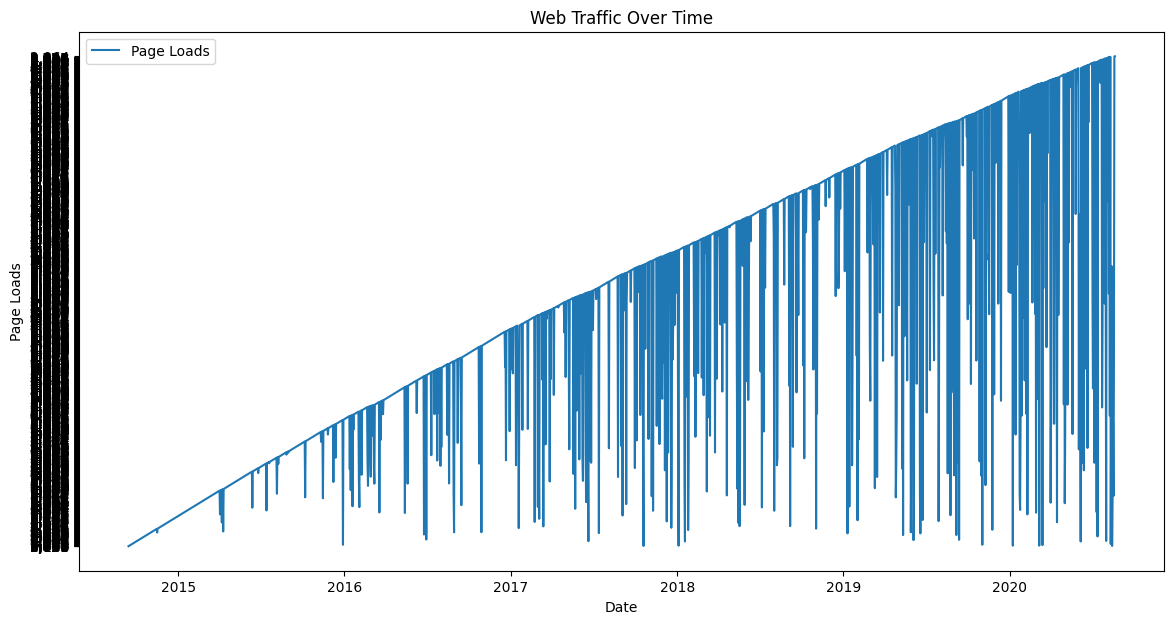

In [3]:
# Plot the time series data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Page.Loads'], label='Page Loads')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.title('Web Traffic Over Time')
plt.legend()
plt.show()


In [4]:

# Convert 'Page.Loads' column to numeric, removing commas
df['Page.Loads'] = df['Page.Loads'].str.replace(',', '').astype(float)

# Use only the 'Page.Loads' column for forecasting
data = df[['Page.Loads']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Convert the time series data into sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

# Define sequence length
sequence_length = 30  # e.g., use past 30 days to predict the next day

# Create sequences and labels
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and test sets
split_ratio = 0.8
split = int(len(X) * split_ratio)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Display the shapes of the training and test sets
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Define the GRU model
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Create the LSTM and GRU models
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]))

# Train the LSTM model
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Train the GRU model
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


(1709, 30, 1) (1709, 1)
(428, 30, 1) (428, 1)
Epoch 1/50
43/43 [==============================] - 8s 63ms/step - loss: 0.0507 - val_loss: 0.0325
Epoch 2/50
43/43 [==============================] - 1s 31ms/step - loss: 0.0288 - val_loss: 0.0315
Epoch 3/50
43/43 [==============================] - 1s 32ms/step - loss: 0.0281 - val_loss: 0.0313
Epoch 4/50
43/43 [==============================] - 1s 32ms/step - loss: 0.0276 - val_loss: 0.0297
Epoch 5/50
43/43 [==============================] - 1s 31ms/step - loss: 0.0271 - val_loss: 0.0295
Epoch 6/50
43/43 [==============================] - 1s 32ms/step - loss: 0.0280 - val_loss: 0.0298
Epoch 7/50
43/43 [==============================] - 1s 32ms/step - loss: 0.0269 - val_loss: 0.0301
Epoch 8/50
43/43 [==============================] - 2s 46ms/step - loss: 0.0263 - val_loss: 0.0296
Epoch 9/50
43/43 [==============================] - 2s 54ms/step - loss: 0.0264 - val_loss: 0.0284
Epoch 10/50
43/43 [==============================] - 1s 32ms/st

In [6]:
# Make predictions
lstm_predictions = lstm_model.predict(X_test)
gru_predictions = gru_model.predict(X_test)

# Combine predictions (e.g., by averaging)
combined_predictions = (lstm_predictions + gru_predictions) / 2

# Inverse transform the predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)
combined_predictions = scaler.inverse_transform(combined_predictions)

# Inverse transform the test labels
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))


14/14 [==============================] - 0s 8ms/step


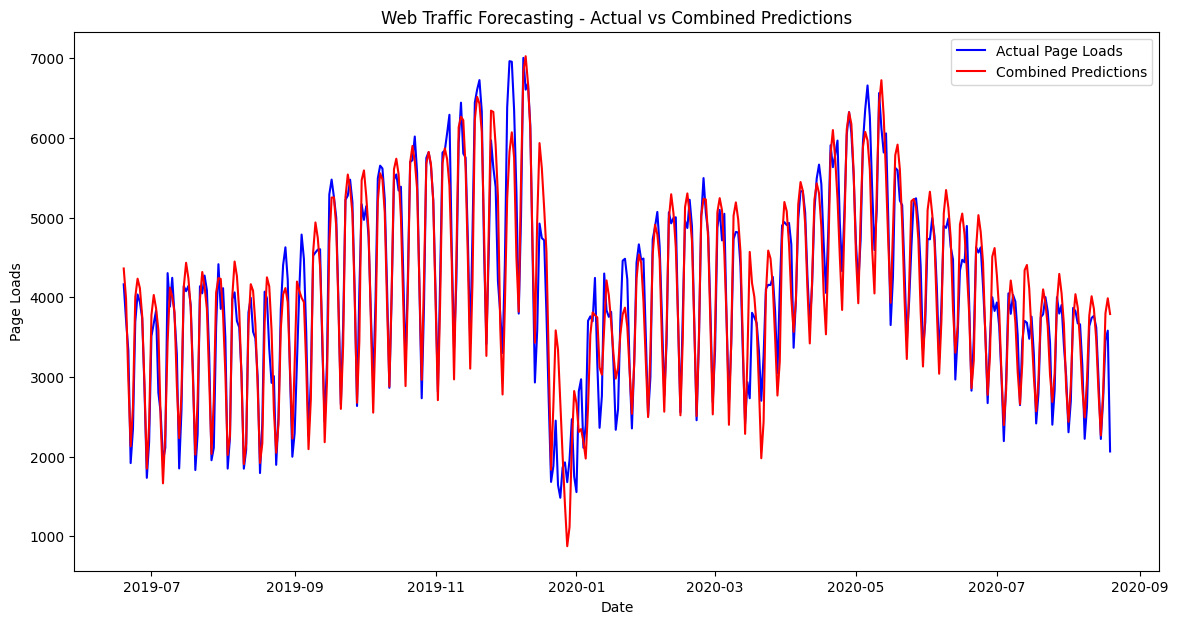

In [7]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(df.index[split + sequence_length:], y_test_inverse, color='blue', label='Actual Page Loads')
plt.plot(df.index[split + sequence_length:], combined_predictions, color='red', label='Combined Predictions')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.title('Web Traffic Forecasting - Actual vs Combined Predictions')
plt.legend()
plt.show()


1/1 [==============================] - 0s 31ms/step


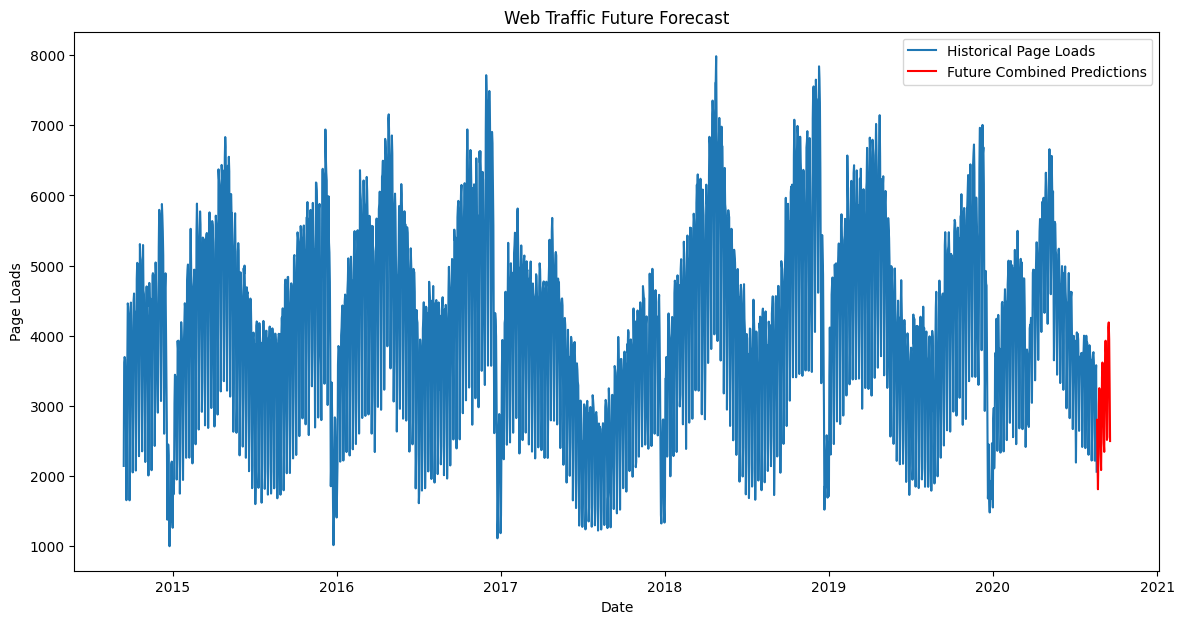

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to make future forecasts
def make_future_forecasts(model, data, steps, sequence_length):
    current_sequence = data[-sequence_length:]
    future_predictions = []
    for _ in range(steps):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(prediction[0, 0])
        current_sequence = np.append(current_sequence[1:], prediction, axis=0)
    return np.array(future_predictions)

# Number of days to forecast
future_steps = 30

# Make future forecasts using the combined model (LSTM + GRU)
lstm_future_predictions = make_future_forecasts(lstm_model, scaled_data, future_steps, sequence_length)
gru_future_predictions = make_future_forecasts(gru_model, scaled_data, future_steps, sequence_length)

# Combine future predictions
combined_future_predictions = (lstm_future_predictions + gru_future_predictions) / 2

# Inverse transform the future predictions
combined_future_predictions = scaler.inverse_transform(combined_future_predictions.reshape(-1, 1))

# Create a date range for the future predictions
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_steps)

# Plot the future predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Page.Loads'], label='Historical Page Loads')
plt.plot(future_dates, combined_future_predictions, color='red', label='Future Combined Predictions')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.title('Web Traffic Future Forecast')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error
import math

# Make predictions on the test set
lstm_test_predictions = lstm_model.predict(X_test)
gru_test_predictions = gru_model.predict(X_test)

# Combine test predictions
combined_test_predictions = (lstm_test_predictions + gru_test_predictions) / 2

# Inverse transform the test predictions
lstm_test_predictions = scaler.inverse_transform(lstm_test_predictions)
gru_test_predictions = scaler.inverse_transform(gru_test_predictions)
combined_test_predictions = scaler.inverse_transform(combined_test_predictions)

# Inverse transform the test labels
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MSE for the combined test predictions
rmse = math.sqrt(mean_squared_error(y_test_inverse, combined_test_predictions))
mse = mean_squared_error(y_test_inverse, combined_test_predictions)

print(f'RMSE for Combined Test Predictions: {rmse}')
print(f'MSE for Combined Test Predictions: {mse}')


14/14 [==============================] - 0s 8ms/step
RMSE for Combined Test Predictions: 412.00698517192495
MSE for Combined Test Predictions: 169749.7558304588


In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate the LSTM model on the test set
lstm_test_loss = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test Loss (MSE): {lstm_test_loss}")

# Predict on the test set
lstm_test_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values
lstm_test_predictions = scaler.inverse_transform(lstm_test_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MSE for LSTM model
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_test_predictions))
lstm_mse = mean_squared_error(y_test_actual, lstm_test_predictions)

print(f"LSTM Test RMSE: {lstm_rmse}")
print(f"LSTM Test MSE: {lstm_mse}")

# Evaluate the GRU model on the test set
gru_test_loss = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"GRU Test Loss (MSE): {gru_test_loss}")

# Predict on the test set
gru_test_predictions = gru_model.predict(X_test)

# Inverse transform the predictions and actual values
gru_test_predictions = scaler.inverse_transform(gru_test_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MSE for GRU model
gru_rmse = np.sqrt(mean_squared_error(y_test_actual, gru_test_predictions))
gru_mse = mean_squared_error(y_test_actual, gru_test_predictions)

print(f"GRU Test RMSE: {gru_rmse}")
print(f"GRU Test MSE: {gru_mse}")

# Combine predictions from LSTM and GRU models
combined_test_predictions = (lstm_test_predictions + gru_test_predictions) / 2

# Calculate RMSE and MSE for combined model
combined_rmse = np.sqrt(mean_squared_error(y_test_actual, combined_test_predictions))
combined_mse = mean_squared_error(y_test_actual, combined_test_predictions)

print(f"Combined Test RMSE: {combined_rmse}")
print(f"Combined Test MSE: {combined_mse}")


LSTM Test Loss (MSE): 0.004735566675662994
14/14 [==============================] - 0s 9ms/step
LSTM Test RMSE: 480.46950348557334
LSTM Test MSE: 230850.94377967337
GRU Test Loss (MSE): 0.0029625946190208197
14/14 [==============================] - 0s 9ms/step
GRU Test RMSE: 380.0283111404987
GRU Test MSE: 144421.5172682997
Combined Test RMSE: 412.0069870925901
Combined Test MSE: 169749.75741311372


14/14 [==============================] - 0s 10ms/step - loss: 0.0047
LSTM Model Loss: 0.004735566675662994
14/14 [==============================] - 0s 8ms/step - loss: 0.0030
GRU Model Loss: 0.0029625946190208197


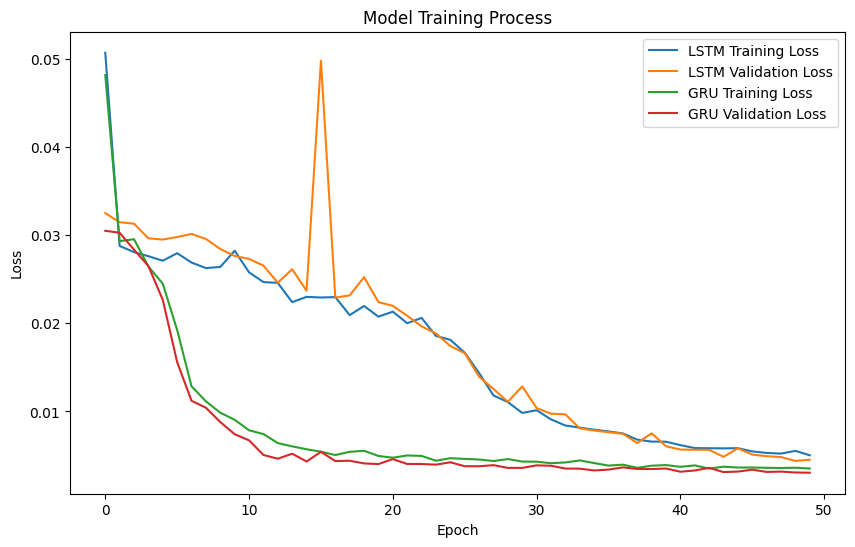

In [12]:
# Evaluate the LSTM model
lstm_loss = lstm_model.evaluate(X_test, y_test)
print("LSTM Model Loss:", lstm_loss)

# Evaluate the GRU model
gru_loss = gru_model.evaluate(X_test, y_test)
print("GRU Model Loss:", gru_loss)

# Visualize the training process (loss over epochs)
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.plot(gru_history.history['loss'], label='GRU Training Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation Loss')
plt.title('Model Training Process')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

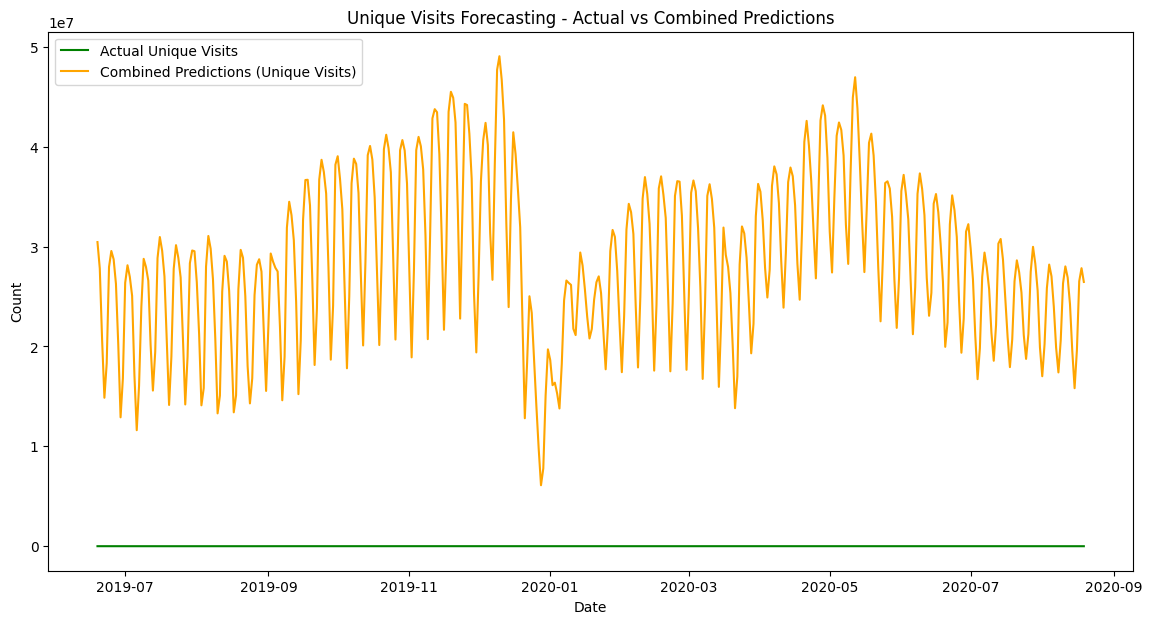

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inverse transform the predicted values to their original scale
y_test_inverse = scaler.inverse_transform(y_test)
combined_predictions_inverse = scaler.inverse_transform(combined_predictions)

# Determine the appropriate date range for the actual and predicted values
date_range = df.index[split + sequence_length:split + sequence_length + len(y_test)]

# Plot the actual vs predicted values for Unique Visits
plt.figure(figsize=(14, 7))
# Access the first (and only) column using index 0
plt.plot(date_range, y_test_inverse[:, 0], color='green', label='Actual Unique Visits')
plt.plot(date_range, combined_predictions_inverse[:, 0], color='orange', label='Combined Predictions (Unique Visits)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Unique Visits Forecasting - Actual vs Combined Predictions')
plt.legend()
plt.show()


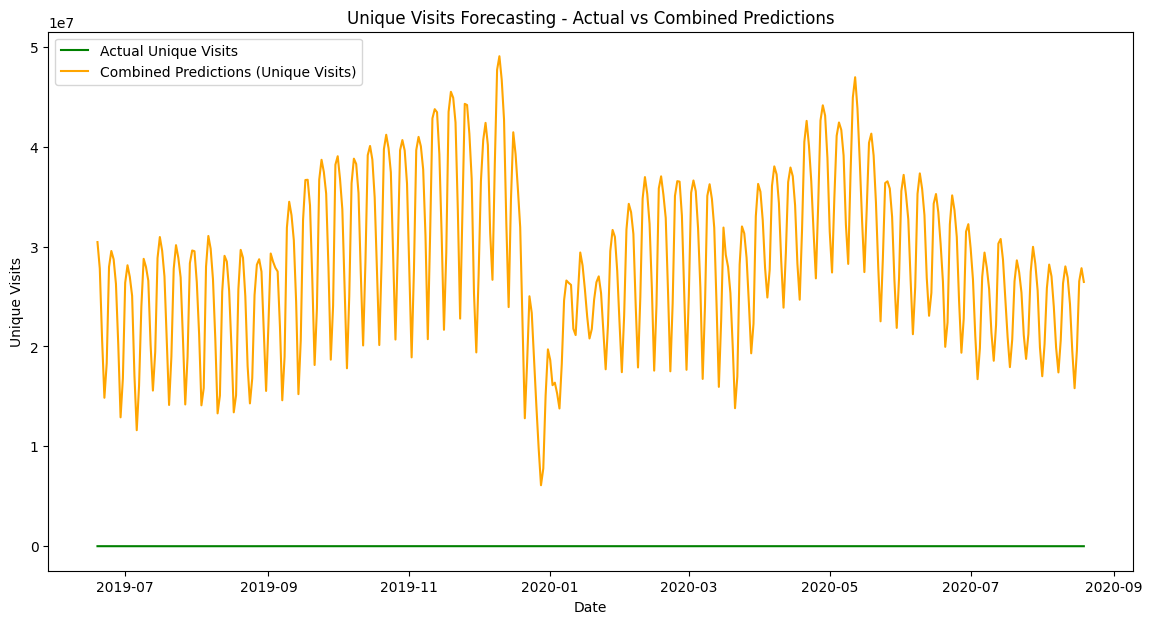

In [17]:
# Inverse transform the predicted values to their original scale
y_test_inverse = scaler.inverse_transform(y_test)
combined_predictions_inverse = scaler.inverse_transform(combined_predictions)

# Plot the actual vs predicted values for Unique Visits
plt.figure(figsize=(14, 7))
# Access the first (and only) column using index 0
plt.plot(df.index[split + sequence_length:], y_test_inverse[:, 0], color='green', label='Actual Unique Visits')
plt.plot(df.index[split + sequence_length:], combined_predictions_inverse[:, 0], color='orange', label='Combined Predictions (Unique Visits)')
plt.xlabel('Date')
plt.ylabel('Unique Visits')
plt.title('Unique Visits Forecasting - Actual vs Combined Predictions')
plt.legend()
plt.show()


In [21]:
# Assuming y_test contains true labels and y_pred contains predicted labels
# If the model outputs probabilities, convert them to class predictions

# For binary classification (0 or 1)
y_pred = (lstm_model.predict(X_test) > 0.5).astype("int32")

# For multi-class classification
# y_pred = np.argmax(lstm_model.predict(X_test), axis=-1)

14/14 [==============================] - 0s 13ms/step


In [22]:
# Assuming y_test contains the true labels
# For binary classification, ensure y_test is in the correct format (0 or 1)
# For multi-class classification, ensure y_test is in the correct format (e.g., one-hot encoded to label encoded)

# For binary classification (0 or 1)
# y_test should be the correct shape and type

# For multi-class classification
# y_test = np.argmax(y_test, axis=-1)

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


Mean Squared Error: 0.14205377177800152
Mean Absolute Error: 0.3592532332807727
R-squared: -3.925935091933594
